## Preprocessing

#### paste following lines into anaconda prompt (as admin) and press enter: 
#### conda install -c huggingface -c conda-forge datasets
#### conda install -c anaconda gensim


In [10]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re, string, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy import sparse


# Train test split and class distribution

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\malte\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using custom data configuration default
Reusing dataset ag_news (C:\Users\malte\.cache\huggingface\datasets\ag_news\default\0.0.0\bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 400.14it/s]


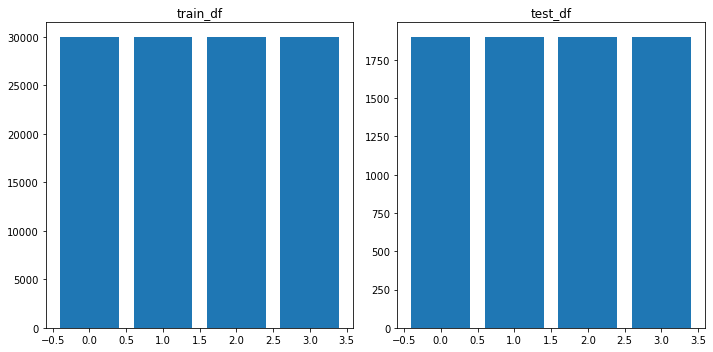

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# train-test split
dataset = load_dataset("ag_news")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
del dataset

def class_distribution():
    
    # checking class distribution
    plt.figure(figsize=(10,5))

    ## train data
    plt.subplot(1,2,1)
    train_df_target = train_df['label']
    class_dist = pd.Series(train_df_target).value_counts()
    plt.title('train_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    ## test data
    plt.subplot(1,2,2)
    test_df_target = test_df['label']
    class_dist = pd.Series(test_df_target).value_counts()
    plt.title('test_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    plt.show()

def balanced_fractionize(df, frac):
    
    frac_df = df.sample(frac=frac, random_state=42)
    frac_data, frac_target = frac_df['text'].values.reshape(-1, 1), frac_df['label'].values.reshape(-1, 1)
    
    sampler = RandomUnderSampler()
    bal_frac_data, bal_frac_target = sampler.fit_resample(frac_data, frac_target)
    
    class_dist = pd.Series(bal_frac_target).value_counts()
    plt.bar(class_dist.index, class_dist)
    plt.ylabel("Frequency")
    plt.show()
    
    return pd.DataFrame(bal_frac_data, columns = ['text']), pd.DataFrame(bal_frac_target, columns = ['label'])

class_distribution()

In [3]:
#initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def preprocessing(text):
    
    # convert to lowercase and remove spaces at beginning and ending
    text = text.lower().strip()
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove html code
    text= re.sub('<.*?>', '', text) 
    
    # remove special characters
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove digits
    text = re.sub(r'\d',' ',text)
    
    # replace multiple whitespaces with one
    text = re.sub('\s+', ' ', text)
    
    # stop word removal
    clean_text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # tonkenize & lemmatize
    word_pos_tags = nltk.pos_tag(word_tokenize(clean_text)) # -> list of tuples (word, pos_tag) [('computer', 'NN'), ('word', 'tag')]
    lem_text = ' '.join([wnl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

    return lem_text

 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # default pos
        return wordnet.NOUN
    


In [ ]:
# execute preprocessing for training set
train_df['text'] = train_df['text'].apply(lambda x: preprocessing(x))
train_df.to_csv('training_data.csv', sep=';', encoding='utf-8', index=False)
train_df.head()

## Vectorization

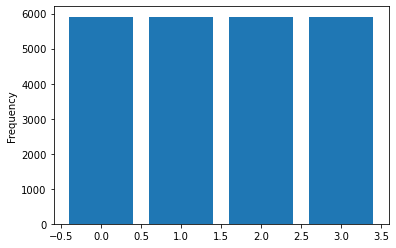

In [4]:
# read in preprocessed training data if necessary
train_df = pd.read_csv('preprocessed_training_data.csv', sep=';', encoding='utf-8')

#fractionize and undersample data
train_data, train_target = balanced_fractionize(train_df, 0.2)

#Tokenize
def get_train_tokens(df_data):
    return [word_tokenize(text) for text in df_data['text']]

### Count vectors and Tf-idf vectors

In [5]:
def get_tfid_vectors(df_data, param_comb={'analyzer': 'word'}):
    tfidf_vectorizer = TfidfVectorizer(**param_comb)
    return tfidf_vectorizer.fit_transform(df_data['text'])

def get_count_vectors(df_data, param_comb={'analyzer': 'word'}):
    count_vectorizer = CountVectorizer(**param_comb)
    return count_vectorizer.fit_transform(df_data['text'])

### Word2Vec SkipGram & CBOW

In [6]:
# returns mean w2v vector for list of specified words
def get_embedding(model, text):
    existing_words = [word for word in text if word in list(model.wv.index_to_key)]
    if existing_words:
        embedding = np.zeros((len(existing_words), model.vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = model.wv[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)

    
# need to specify parameters in param_comb in form of a dict  
def get_w2v_cbow_embeddings(tokens, param_comb):
    w2v_cbow = Word2Vec(tokens, **param_comb)
    # get mean vector for each article description for both models
    return sparse.csr_matrix(  np.array([get_embedding(w2v_cbow, text) for text in tokens]) )

# need to specify parameters in param_comb in form of a dict  
def get_w2v_skipg_embeddings(tokens, param_comb):
    w2v_skipg = Word2Vec(tokens, **param_comb, sg = 1)
    # get mean vector for each article description for both models
    return sparse.csr_matrix( np.array([get_embedding(w2v_skipg, text) for text in tokens]) )

### fastText

In [7]:
# need to specify parameters in param_comb in form of a dict  
def get_fasttext_embeddings(tokens, param_comb):
    fasttext = FastText(**param_comb)
    fasttext.build_vocab(corpus_iterable=tokens)
    fasttext.train(corpus_iterable=tokens, total_examples=len(tokens), epochs=10)
    return sparse.csr_matrix( np.array([get_embedding(fasttext, text) for text in tokens]) )

### GloVe

In [36]:
# write content into file
with open('corpus.txt', 'w') as f:
    for text in train_data['text'].tolist():
        f.write(text + '\n')
# train vectors with https://github.com/stanfordnlp/GloVe with standard parameters
#Example vectors uploaded to Git were trained with 0.2 percent of the data

In [73]:
def get_glove_document_vector(text, vocab, vectors, vector_size):
    existing_words = [word for word in text if word in vocab]
    if existing_words:
        embedding = np.zeros((len(existing_words), vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = vectors[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)
    

# needs tokens from same fraction of training data as the GloVe embeddings were trained with
def get_glove_embeddings(tokens):
    vocab = []
    vectors = {}
    with open('vocab.txt') as f:
        for ln in f:
            words = ln.split()
            vocab = vocab + words[:1]
    with open('vectors.txt') as f:
        for ln in f:
            word = ln.split()[0]
            vector = [float(number) for number in ln.split()[1:]]
            vectors[word] = vector
            
    return sparse.csr_matrix( np.array([get_glove_document_vector(text, vocab, vectors, len(vector)) for text in tokens]) )

In [8]:
vectorizer_names = ["tfidf_vectors", "count_vectors", "w2v_cbow", "w2v_skipg", "fasttext", "GloVe"]

#returns vector-matrix with specified vectorizer on specified data
def get_vectorMatrix(vectorizer_name, df_data):
    for vectorizer_name in vectorizer_names:
        if vectorizer_name == "tfidf_vectors":
            return get_tfid_vectors(df_data)
        elif vectorizer_name == "count_vectors":
            return get_count_vectors(train_data)
        elif vectorizer_name == "w2v_cbow":
            train_tokens = get_train_tokens(train_data)
            return get_w2v_cbow_embeddings(train_tokens)
        elif vectorizer_name == "w2v_skipg":
            train_tokens = get_train_tokens(train_data)
            return get_w2v_skipg_embeddings(train_tokens)
        elif vectorizer_name == "fasttext":
            train_tokens = get_train_tokens(train_data)
            return get_fasttext_embeddings(train_tokens)
        elif vectorizer_name == "GloVe":
            train_tokens = get_train_tokens(train_data)
            return get_glove_embeddings(train_tokens)

## Classification

### Hyperparameter Tuning

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std

# hyperparameter tuning
def param_search(vector_matrix, vector_matrix_name, estimator):
    
    estimator_name = estimator['name']
    parameters = estimator['parameters']
    estimator = estimator['estimator']
    
    # configure the cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # enumerate splits
    outer_results = list()
    X = vector_matrix.toarray()
    y = train_target['label']
    
    for train_ix, test_ix in cv_outer.split(X,y):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
    
        # specify the nested cross validation
        nested_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

        # create the grid search instance
        search = GridSearchCV(estimator, parameters, scoring='accuracy', cv=nested_cv, n_jobs=-1, refit=True)
        
        # execute search
        result = search.fit(vector_matrix.toarray(), train_target['label'])
        
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # evaluate model on the hold out dataset
        predictions = best_model.predict(X_test)
        
        # evaluate the model
        acc = accuracy_score(y_test, predictions)
        
        # store the result
        outer_results.append(acc)
        
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    # summarize the estimated performance of the model
    accuracy_mean = mean(outer_results)
    
    #print the best parameter setting
    print("Classifier: {}".format(estimator_name))
    print("Vectorizer: {}".format(vector_matrix_name))
    print("Mean Accuracy: {}".format(accuracy_mean))
    print()
    
    return accuracy_mean, best_model

In [76]:
# tune for the best vectorizer-estimator combination
def hyper_tune():
    
    kNeighbors_parameters = {
        'leaf_size': range(25,35),
        'n_neighbors': range(2, 9)
    }
    
    decisionTree_parameters = {
        'criterion':['gini', 'entropy'], 
        'max_depth':[ 2, 3, 4, 5, None]
    }
    
    gaussianNB_parameters = {
        'var_smoothing': [np.logspace(0,-9, num=10)]
    }
    
    svc_parameters = {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['auto', 'scale', 'float'],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    
    mlpClassifier_parameters = {
        'learning_rate': ['constant', 'adaptive'],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam']
    }
    
    
    wordEmbedding_std_parameters = {
        'window': 5,
        'vector_size': 200,
        'min_count': 5
    }

    
    
    # ------ VECTORIZERS ------
    train_tokens = get_train_tokens(train_data)
    
    #TODO: add the other matrices, when done
    vectorizer_values = [
        get_tfid_vectors(train_data), get_count_vectors(train_data),
        get_w2v_cbow_embeddings(train_tokens, wordEmbedding_std_parameters), get_w2v_skipg_embeddings(train_tokens, wordEmbedding_std_parameters),
        get_fasttext_embeddings(train_tokens, wordEmbedding_std_parameters), get_glove_embeddings(train_tokens)
    ]
    
    vectorizer_names = ["tfidf_vectors", "count_vectors", "w2v_cbow", "w2v_skipg", "fasttext", "GloVe"]
    vectorizers = dict(zip(vectorizer_names, vectorizer_values))
    
    del train_tokens
    
    # ------ ESTIMATORS ------
    #TODO: add more estimators
    estimators = {
        'KNeighborsClassifier': { 'name': 'KNeighborsClassifier', 'estimator': KNeighborsClassifier(), 'parameters': kNeighbors_parameters }#,
#         'DecisionTreeClassifier': { 'name': 'DecisionTreeClassifier', 'estimator': DecisionTreeClassifier(), 'parameters': decisionTree_parameters },
#        'GaussianNB': { 'name': 'GaussianNB', 'estimator': GaussianNB(), 'parameters': gaussianNB_parameters },
#         'SVC': { 'name': 'SVC', 'estimator': SVC(), 'parameters': svc_parameters },
#         'MLPClassifier': { 'name': 'MLPClassifier', 'estimator': MLPClassifier(), 'parameters': mlpClassifier_parameters }
    }
    
    best_score = 0
    for vectorizer in vectorizers:
        for estimator in estimators:
            
            score, model = param_search( vectorizers[vectorizer], vectorizer, estimators[estimator] )
            if score > best_score:
                best_score = score
                best_estimator_name = estimator
                best_vectorizer_name = vectorizer
                best_model = model

    print("\nThe best performance is reached with the estimator " + best_estimator_name + " and the vectorizer " + best_vectorizer_name + " with an accuracy of " + str(best_score) )
    return best_model, best_vectorizer_name, vectorizers


#the best performing model and vectorizer
model, vectorizer_name, vectorizers = hyper_tune()

>acc=0.892, est=0.850, cfg={'leaf_size': 25, 'n_neighbors': 7}
>acc=0.893, est=0.850, cfg={'leaf_size': 25, 'n_neighbors': 7}
>acc=0.893, est=0.850, cfg={'leaf_size': 25, 'n_neighbors': 7}
Classifier: KNeighborsClassifier
Vectorizer: tfidf_vectors
Mean Accuracy: 0.8923194381003402


The best performance is reached with the estimator KNeighborsClassifier and the vectorizer tfidf_vectors with an accuracy of 0.8923194381003402


In [ ]:
#Quick showcase, applying the model again on the training data

vector_matrix = get_vectorMatrix(vectorizer_name, train_data)
predictions = model.predict(vector_matrix)
# evaluate the model
acc = accuracy_score(train_target, predictions)
print(acc)

#TODO: apply model on the test data and evaluate it

## Hyperparameter tuning for Vectorizors on a given classifier
### approach https://pdfs.semanticscholar.org/d6e3/65ad12d9ba027a456ddea56bd7f8c060de8a.pdf
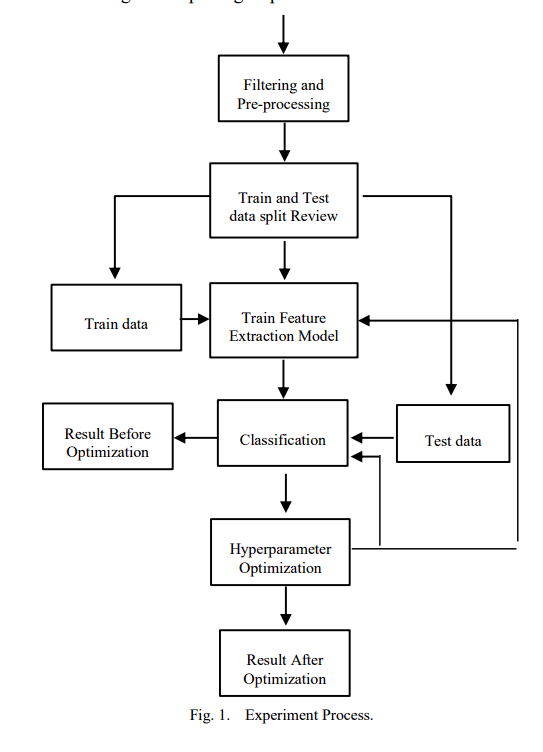
#### -> First train classifiers with vectorizers having standard parameters, then hypertune Vectorizors and train best classifier again with different different vectorizer settings
#### GloVe is not included, since its trained in C

In [24]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# vectorizer_name is one of the following 'w2v_cbow' / 'w2v_skipg' / 'fasttext' / 'tfidf_vectors' / 'count_vectors'
# returns best parameter combination for vectorizer 'vectorizer_name' with given classifier
def hypertuneVectorizor(estimator, vectorizer_name):
    
    best_acc = 0
    best_model = {}
    parameters = ParameterGrid({})
    
    
    
    if vectorizer_name == 'tfidf_vectors' or vectorizer_name == 'count_vectors':
        
        parameters = ParameterGrid({
        'ngram_range': [(1,1), (1,2)], #[(1,1), (1,2), (2,2)]
        'max_features': [50000, 100000], #[None, 15000, 25000, 50000, 100000, 200000, 400000]
        'min_df': [2, 5]
        })
        
        X_train, X_test, y_train, y_test = train_test_split(train_data, train_target['label'], test_size=0.2, random_state=0)
        
    else:
        
        parameters = ParameterGrid({
        'min_count': [2, 5], #[2, 5, 8]
        'vector_size': [100], #[50, 100, 200, 300]
        'window': [5, 10] #[5, 10]
        })
        
        tokens = get_train_tokens(train_data)
        X_train, X_test, y_train, y_test = train_test_split(tokens, train_target['label'], test_size=0.2, random_state=0)
        del tokens

    
    for param_comb in parameters:
         
        if vectorizer_name == 'tfidf_vectors':
                
            emb_train = get_tfid_vectors(X_train, param_comb)
            emb_test = get_tfid_vectors(X_test, param_comb)
                
        elif vectorizer_name == 'count_vectors':
                
            emb_train = get_count_vectors(X_train,param_comb)
            emb_test = get_count_vectors(X_test,param_comb)
            
        elif vectorizer_name == 'w2v_cbow':
                
            emb_train = get_w2v_cbow_embeddings(X_train, param_comb)
            emb_test = get_w2v_cbow_embeddings(X_test, param_comb)
                
        elif vectorizer_name == 'w2v_skipg':
                
            emb_train = get_w2v_skipg_embeddings(X_train, param_comb)
            emb_test = get_w2v_skipg_embeddings(X_test, param_comb)
                
        elif vectorizer_name == 'fasttext':
                
            emb_train = get_fasttext_embeddings(X_train, param_comb)
            emb_test = get_fasttext_embeddings(X_test, param_comb)
                
                
        model.fit(emb_train.toarray(), y_train)
        predictions = model.predict(emb_test.toarray())
        
        acc = accuracy_score(y_test, predictions)
            
        if acc > best_acc:
            best_acc = acc
            best_model = {'vectorizer': vectorizer_name, 'parameters': param_comb, 'acc': best_acc}
                
    return best_model
    
  

In [25]:
#model, vectorizer_name, vectorizers = hyper_tune()

best_param_model = hypertuneVectorizor(model, vectorizer_name)

ValueError: X has 13192 features, but MultinomialNB is expecting 24665 features as input.